In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-urdu-news-classifier-model/NLP_URDU_NEWS_CLASSIFIER_MODEL.keras
/kaggle/input/nlp-urdu-news-classifier-model/NLP_URDU_NEWS_CLASSIFIER_MODEL.h5
/kaggle/input/kaggle/kaggle.json


In [2]:
!mkdir ~/.kaggle
!cp /kaggle/input/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
# Downloading dataset and unzipping it
!kaggle datasets download -d saurabhshahane/urdu-news-dataset
# !kaggle datasets download -d rmisra/news-category-dataset
!unzip -q urdu-news-dataset.zip -d ./urdu-news-dataset

 69%|███████████████████████████            | 43.0M/62.0M [00:00<00:00, 234MB/s]
100%|███████████████████████████████████████| 62.0M/62.0M [00:00<00:00, 244MB/s]


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
import numpy as np
# from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dropout
from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df = pd.read_csv("urdu-news-dataset/urdu-news-dataset-1M.csv", verbose=True, encoding='ascii', encoding_errors='surrogateescape')


Tokenization took: 3022.72 ms
Type conversion took: 1447.77 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 1443.20 ms
Type conversion took: 660.59 ms
Parser memory cleanup took: 0.01 ms


In [6]:
df.head()

,Index,Headline,News Text,Category,Date,URL,Source,News length
0,0,عالمی بینک عسکریت پسندی سے متاثرہ خاندانوں کی ...,اسلام باد عالمی بینک خیبرپختونخوا کے قبائلی اض...,Business & Economics,2020-12-06,https://www.dawnnews.tv/news/1148499/,Dawn News,1854.0
1,1,مالی سال 2020 ریٹرن فائل کرنے والوں کی تعداد م...,اسلام باد فیڈرل بورڈ ریونیو ایف بی نے دسمبر کی...,Business & Economics,2020-12-06,https://www.dawnnews.tv/news/1148498/,Dawn News,2016.0
2,2,جاپان کو سندھ کے خصوصی اقتصادی زون میں سرمایہ ...,اسلام باد بورڈ انویسٹمنٹ بی او ئی کے چیئرمین ع...,Business & Economics,2020-12-05,https://www.dawnnews.tv/news/1148433/,Dawn News,2195.0
3,3,برامدات 767 فیصد بڑھ کر ارب 16 کروڑ ڈالر سے زائد,اسلام اباد پاکستان میں ماہ نومبر میں مسلسل تیس...,Business & Economics,2020-12-05,https://www.dawnnews.tv/news/1148430/,Dawn News,2349.0
4,4,کے الیکٹرک کو اضافی بجلی گیس کی فراہمی کے قانو...,اسلام باد نیشنل ٹرانسمیشن اینڈ ڈسپیچ کمپنی این...,Business & Economics,2020-12-05,https://www.dawnnews.tv/news/1148421/,Dawn News,2655.0


In [7]:
unique_categories = df['Category'].unique()
print(unique_categories)
print(len(unique_categories))


['Business & Economics' 'Entertainment' 'Science & Technology' 'Sports'
 nan]
5


In [8]:

df2 = df.iloc[:, [1, 2, 3, 7]]

# Display the DataFrame with selected columns
print(df2.head())


                                            Headline  \
0  عالمی بینک عسکریت پسندی سے متاثرہ خاندانوں کی ...   
1  مالی سال 2020 ریٹرن فائل کرنے والوں کی تعداد م...   
2  جاپان کو سندھ کے خصوصی اقتصادی زون میں سرمایہ ...   
3   برامدات 767 فیصد بڑھ کر ارب 16 کروڑ ڈالر سے زائد   
4  کے الیکٹرک کو اضافی بجلی گیس کی فراہمی کے قانو...   

                                           News Text              Category  \
0  اسلام باد عالمی بینک خیبرپختونخوا کے قبائلی اض...  Business & Economics   
1  اسلام باد فیڈرل بورڈ ریونیو ایف بی نے دسمبر کی...  Business & Economics   
2  اسلام باد بورڈ انویسٹمنٹ بی او ئی کے چیئرمین ع...  Business & Economics   
3  اسلام اباد پاکستان میں ماہ نومبر میں مسلسل تیس...  Business & Economics   
4  اسلام باد نیشنل ٹرانسمیشن اینڈ ڈسپیچ کمپنی این...  Business & Economics   

   News length  
0       1854.0  
1       2016.0  
2       2195.0  
3       2349.0  
4       2655.0  


In [9]:
print(df2[df2['Headline'] == ''])
print(df2[df2['News Text'] == ''])



Empty DataFrame
Columns: [Headline, News Text, Category, News length]
Index: []
Empty DataFrame
Columns: [Headline, News Text, Category, News length]
Index: []


In [10]:
null_counts = df2.isnull().sum()

print(null_counts)

null_rows = df2[df2.isnull().any(axis=1)]

# Display the rows with null values
print(null_rows)

Headline       0
News Text      0
Category       1
News length    1
dtype: int64
                                                 Headline  \
111860  پاکستان کو براستہ افغانستان ریلوے لائن کی ازبک...   

                                               News Text Category  News length  
111860  ازبک وزیرخارجہ کی شاہ محمودسے ملاقاتتعاون بڑھان�      NaN          NaN  


In [11]:
df2 = df2.dropna()


null_rows = df2[df2.isnull().any(axis=1)]

print(null_rows)

Empty DataFrame
Columns: [Headline, News Text, Category, News length]
Index: []


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


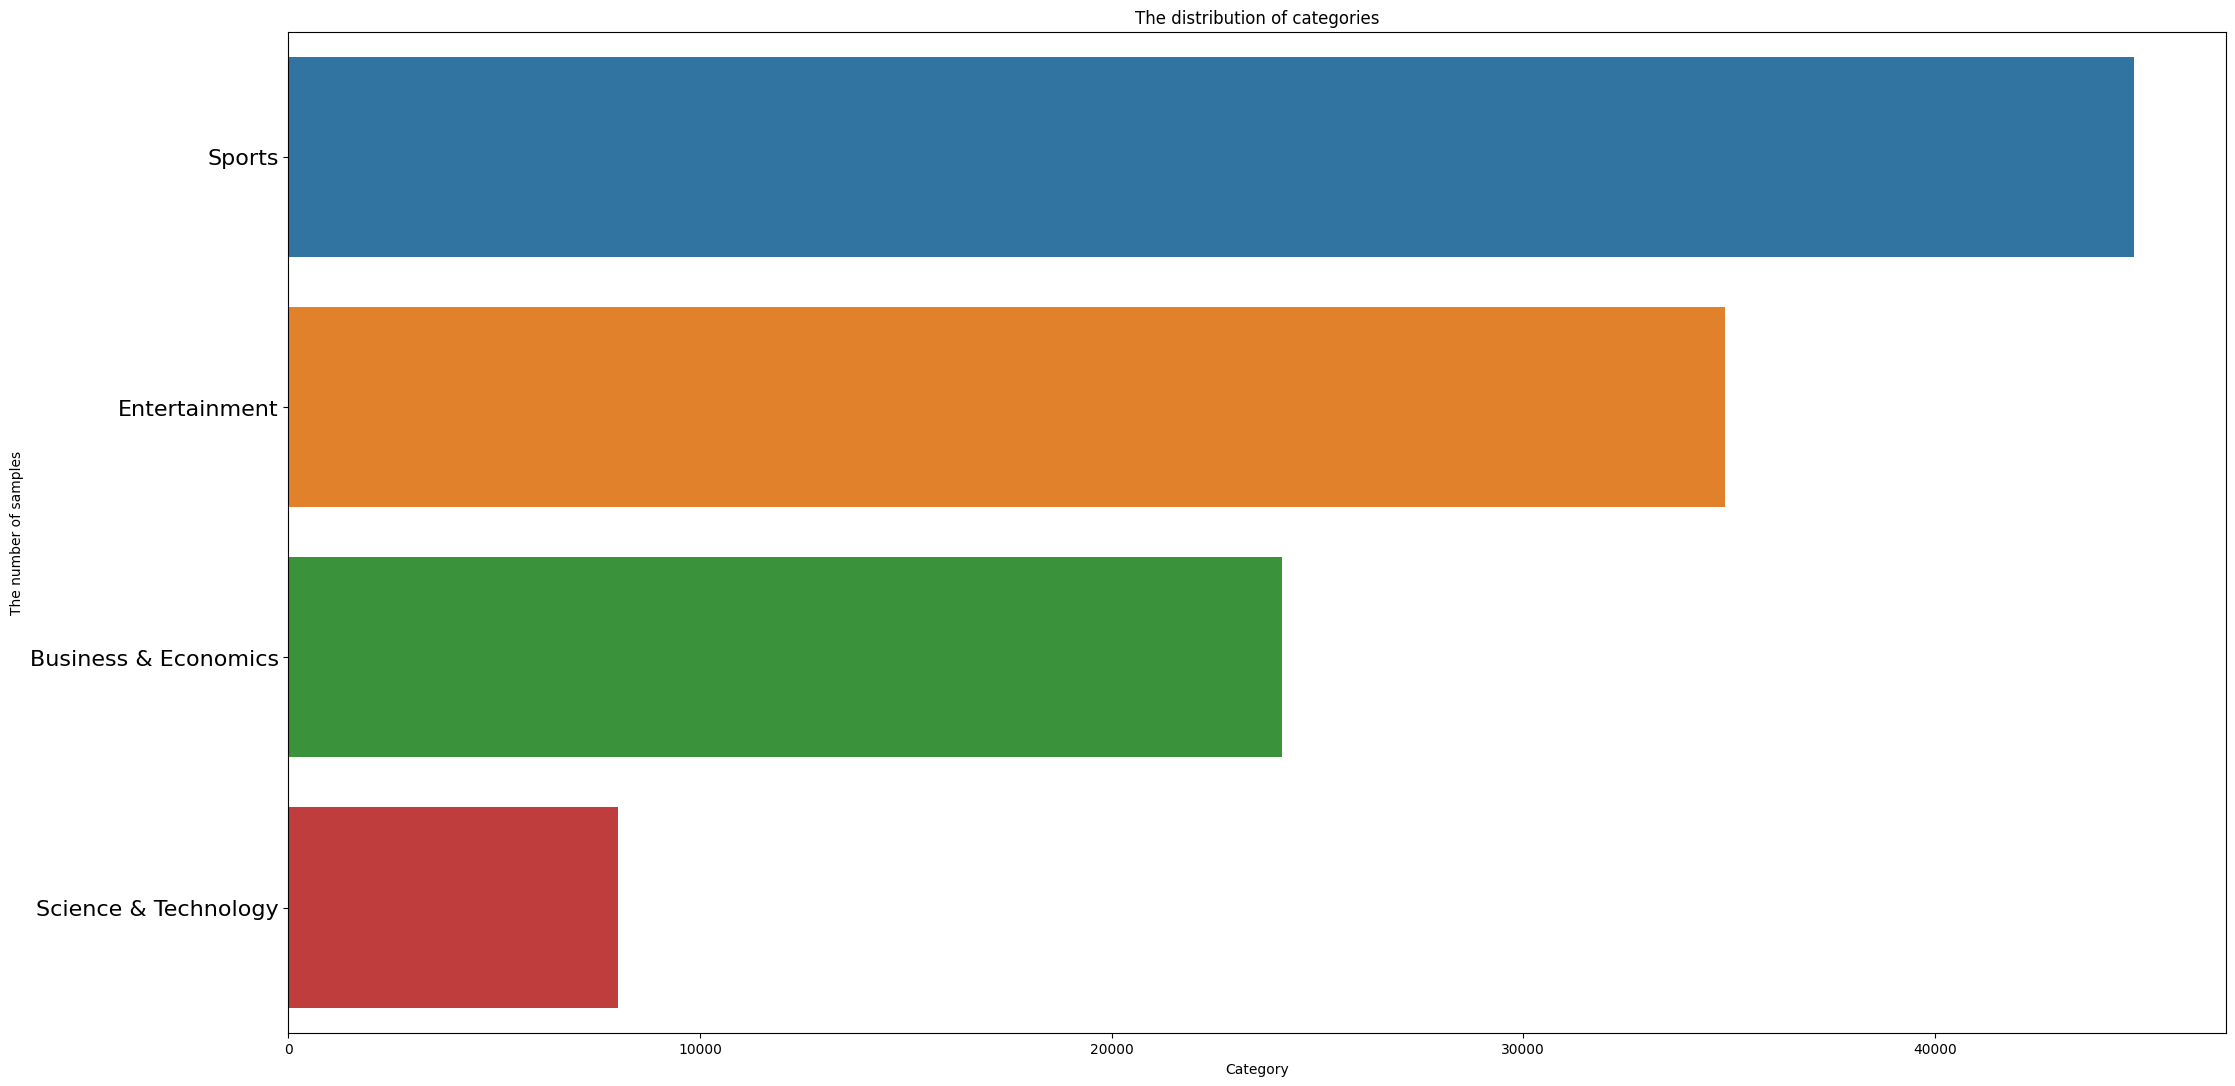

In [12]:
plt.figure(figsize=(25,13))
sns.barplot(y=df2['Category'].value_counts().index,x=df2['Category'].value_counts().values)
plt.title("The distribution of categories")
plt.xlabel("Category")
plt.ylabel("The number of samples")

plt.yticks(rotation=0,fontsize = 16)
plt.show()

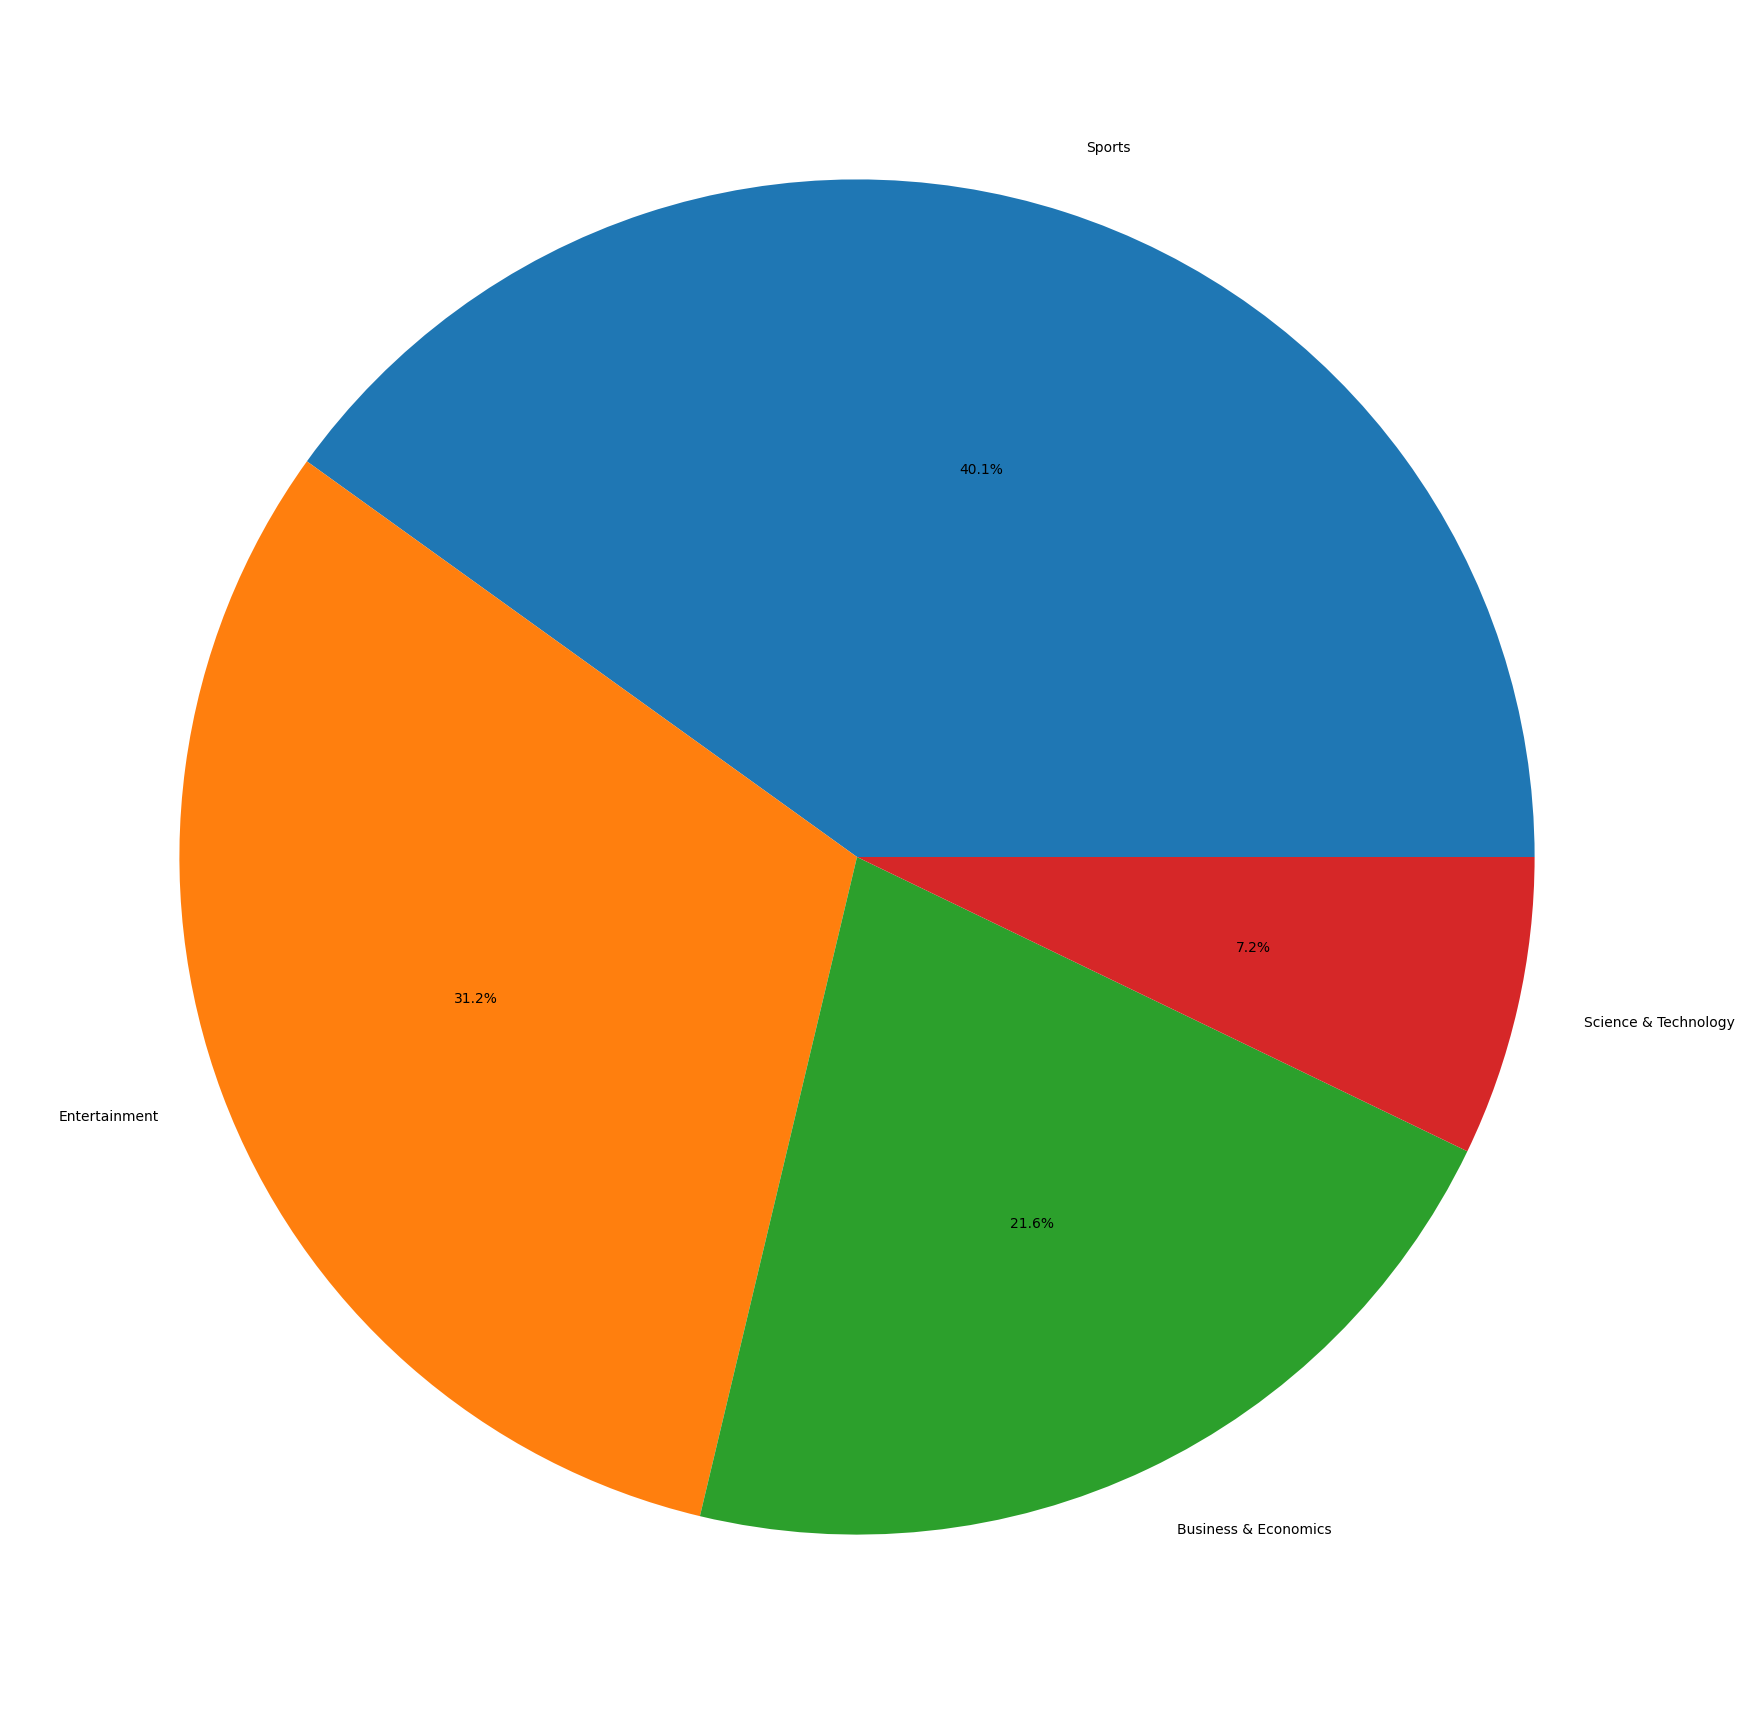

In [13]:
plt.figure(figsize=(22,22))
plt.pie(df2['Category'].value_counts().values, autopct="%1.1f%%", labels=df2['Category'].value_counts().index)
plt.show()

In [14]:
df3=df2.copy()
df3['Full Article'] = df3['Headline'] + " " + df3['News Text']
df3.head()

,Headline,News Text,Category,News length,Full Article
0,عالمی بینک عسکریت پسندی سے متاثرہ خاندانوں کی ...,اسلام باد عالمی بینک خیبرپختونخوا کے قبائلی اض...,Business & Economics,1854.0,عالمی بینک عسکریت پسندی سے متاثرہ خاندانوں کی ...
1,مالی سال 2020 ریٹرن فائل کرنے والوں کی تعداد م...,اسلام باد فیڈرل بورڈ ریونیو ایف بی نے دسمبر کی...,Business & Economics,2016.0,مالی سال 2020 ریٹرن فائل کرنے والوں کی تعداد م...
2,جاپان کو سندھ کے خصوصی اقتصادی زون میں سرمایہ ...,اسلام باد بورڈ انویسٹمنٹ بی او ئی کے چیئرمین ع...,Business & Economics,2195.0,جاپان کو سندھ کے خصوصی اقتصادی زون میں سرمایہ ...
3,برامدات 767 فیصد بڑھ کر ارب 16 کروڑ ڈالر سے زائد,اسلام اباد پاکستان میں ماہ نومبر میں مسلسل تیس...,Business & Economics,2349.0,برامدات 767 فیصد بڑھ کر ارب 16 کروڑ ڈالر سے زا...
4,کے الیکٹرک کو اضافی بجلی گیس کی فراہمی کے قانو...,اسلام باد نیشنل ٹرانسمیشن اینڈ ڈسپیچ کمپنی این...,Business & Economics,2655.0,کے الیکٹرک کو اضافی بجلی گیس کی فراہمی کے قانو...


In [15]:

df4 = df3.iloc[:, [2, 3]]
df4.head()

,Category,News length
0,Business & Economics,1854.0
1,Business & Economics,2016.0
2,Business & Economics,2195.0
3,Business & Economics,2349.0
4,Business & Economics,2655.0


In [16]:
df4['Category'].value_counts()

Category
Sports                  44829
Entertainment           34901
Business & Economics    24131
Science & Technology     7999
Name: count, dtype: int64

In [17]:
df4['TokenizedUrduText'] = df3['Full Article'].apply(lambda x: word_tokenize(x))


/tmp/ipykernel_27/1625323039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['TokenizedUrduText'] = df3['Full Article'].apply(lambda x: word_tokenize(x))


In [18]:
print(df4.head())

               Category  News length  \
0  Business & Economics       1854.0   
1  Business & Economics       2016.0   
2  Business & Economics       2195.0   
3  Business & Economics       2349.0   
4  Business & Economics       2655.0   

                                   TokenizedUrduText  
0  [عالمی, بینک, عسکریت, پسندی, سے, متاثرہ, خاندا...  
1  [مالی, سال, 2020, ریٹرن, فائل, کرنے, والوں, کی...  
2  [جاپان, کو, سندھ, کے, خصوصی, اقتصادی, زون, میں...  
3  [برامدات, 767, فیصد, بڑھ, کر, ارب, 16, کروڑ, ڈ...  
4  [کے, الیکٹرک, کو, اضافی, بجلی, گیس, کی, فراہمی...  


In [19]:
df5=df4.copy()

In [20]:
flattened_words = [word for sublist in df5['TokenizedUrduText'] for word in sublist]

# Step 2: Count occurrences of each word
word_counts = pd.Series(flattened_words).value_counts()

# Step 3: Sort the counts in descending order
sorted_word_counts = word_counts.sort_values(ascending=False)

ranges_to_select = [(0, 16, 1), (17, 19, 1), (22, 24, 1)]

# Use list comprehension to concatenate words from multiple ranges with different steps
selected_words = [word for start, end, step in ranges_to_select for word in sorted_word_counts.index[start:end:step]]

print(selected_words)

['کے', 'میں', 'کی', 'سے', 'نے', 'کا', 'اور', 'کو', 'ہے', 'پر', 'کہ', 'بھی', 'اس', 'ہیں', 'ایک', 'کیا', 'کر', 'ان', 'لیے', 'یہ']


In [21]:

# Function to remove selected words from a list
def remove_selected_words(word_list):
    return [word for word in word_list if word not in selected_words]

# Apply the function to the 'WordsList' column
df5['TokenizedUrduText'] = df5['TokenizedUrduText'].apply(remove_selected_words)




In [22]:
X = df5['TokenizedUrduText'].tolist()
y = df5['Category']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# assigning unique numbers to each word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [25]:
print(X_train_seq[0])

[1086, 175, 2411, 4123, 338445, 1543, 10139, 2411, 4123, 2289, 3640, 395, 1492, 163, 475, 145791, 185, 408, 6761, 325, 85, 27, 11, 13, 1367, 1543, 10139, 137, 3640, 1562, 2440, 3329, 1492, 384, 52, 1225, 29, 474, 801, 4123, 1014, 2878, 13, 81063, 76, 214, 2411, 4123, 56, 3640, 565, 175, 12053, 30, 34306, 837, 1291, 3538, 3, 9692, 10146, 196, 145792, 1119, 37, 23, 1597, 96, 427, 3640, 28133, 175, 4123, 9065, 3, 1465, 865, 1071, 221, 2249, 40, 1460, 9141, 2851, 6468, 5518, 40, 28099, 2452, 308, 69, 12582, 2176, 9279, 4516, 1585, 774, 210, 6761, 3640, 1071, 124, 804, 1440, 129, 755, 4123, 298, 124, 132, 384, 160, 2411, 4123, 2289, 3640, 395, 1492, 163, 475, 145791, 185, 408, 6761, 325, 85, 27, 11, 13, 1367, 1543, 10139, 137, 3640, 1562, 2440, 3329, 1492, 384, 52, 1225, 29, 474, 801, 4123, 1014, 2878, 13, 81063, 76, 214, 2411, 4123, 56, 3640, 565, 175, 12053, 30, 34306, 837, 1291, 3538, 3, 9692, 10146, 196, 145792, 1119, 37, 23, 1597, 96, 427, 3640, 28133, 175, 4123, 9065, 3, 1465, 865, 10

In [26]:



# Pad sequences to a fixed length
max_len = max(len(sequence) for sequence in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')



In [27]:
# print(X_train_padded[0])

In [28]:
print(X_train_padded[0])

[1086  175 2411 ...    0    0    0]


In [29]:
print(X_train_padded.shape[1])

5378


In [30]:
print(max_len)

5378


In [31]:

# Assuming y_train and y_test are lists of string class labels
label_encoder = LabelEncoder()

# Fit and transform labels to numerical values
y_train_numeric = label_encoder.fit_transform(y_train)
y_test_numeric = label_encoder.transform(y_test)
# Convert labels to one-hot encoding
num_classes = len(set(y_train_numeric))  # assuming y_train_numeric contains class labels
y_train_onehot = to_categorical(y_train_numeric, num_classes=num_classes)

num_classes = len(set(y_test_numeric))  # assuming y_test_numeric contains class labels
y_test_onehot = to_categorical(y_test_numeric, num_classes=num_classes)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [32]:

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_train_padded.shape[1]))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.5))  # Add dropout to reduce overfitting
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=256, activation="relu"))
model.add(Dense(units=num_classes, activation='softmax'))



In [33]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5378, 50)          20798350  
                                                                 
 bidirectional (Bidirection  (None, 5378, 128)         58880     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5378, 128)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 5378, 128)         98816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 5378, 128)         0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               9

In [35]:

# Train the model
model.fit(X_train_padded, y_train_onehot, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test_onehot))

Epoch 1/5
1399/1399 [==============================] - 1573s 1s/step - loss: 0.1963 - accuracy: 0.9373 - val_loss: 0.1110 - val_accuracy: 0.9673
Epoch 2/5
1399/1399 [==============================] - 1468s 1s/step - loss: 0.0827 - accuracy: 0.9782 - val_loss: 0.1151 - val_accuracy: 0.9671
Epoch 3/5
1399/1399 [==============================] - 1444s 1s/step - loss: 0.0536 - accuracy: 0.9864 - val_loss: 0.1333 - val_accuracy: 0.9650
Epoch 4/5
1399/1399 [==============================] - 1440s 1s/step - loss: 0.0401 - accuracy: 0.9904 - val_loss: 0.1373 - val_accuracy: 0.9618
Epoch 5/5
1399/1399 [==============================] - 1439s 1s/step - loss: 0.0329 - accuracy: 0.9916 - val_loss: 0.1570 - val_accuracy: 0.9658


In [36]:

model.save('NLP_URDU_NEWS_CLASSIFIER_MODEL.keras')


In [37]:
model = load_model('/kaggle/input/nlp-urdu-news-classifier-model/NLP_URDU_NEWS_CLASSIFIER_MODEL.keras')



In [38]:

y_pred_onehot = model.predict(X_test_padded)

700/700 [==============================] - 246s 346ms/step


In [39]:
# from exponential form to one-hot encoding

y_pred_numeric = np.argmax(y_pred_onehot, axis=1, keepdims=True)

# Find the indices of the maximum values along the second axis (axis=1)
max_indices = np.argmax(y_pred_onehot, axis=1)

# Create a new matrix with 1 at the positions of the maximum values, and 0 elsewhere
result_matrix = np.zeros_like(y_pred_onehot)
rows = np.arange(y_pred_onehot.shape[0])
result_matrix[rows, max_indices] = 1


In [40]:

accuracy = accuracy_score(y_test_onehot, result_matrix)

print(f"Accuracy: {accuracy * 100:.2f}%")




Accuracy: 96.23%


In [41]:

X_joined = [' '.join(tokens) for tokens in X_test]


In [42]:
# Convert predicted labels back to numerical form
y_pred_numeric = np.argmax(y_pred_onehot, axis=1)
y_pred_original = label_encoder.inverse_transform(y_pred_numeric)

# Convert actual labels back to numerical form
y_test_numeric = np.argmax(y_test_onehot, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_numeric)

# Display 5 news samples with actual and predicted labels
for i in range(20):
    print(f"Sample {i+1}:")
    print(f"Actual Label: {y_test_original[i]}")
    print(f"Predicted Label: {y_pred_original[i]}")
    print(f"News Text: {X_joined[i]}")
    print("\n")

Sample 1:
Actual Label: Sports
Predicted Label: Sports
News Text: پاک بھارت ٹاکرا کمزور دل افراد اخری اوور نہ دیکھیں طبی ماہرین کراچیکرکٹ عالمی میلے پاک بھارت ٹاکرا کل ہوگا ڈاکٹرز کہتے دلوں گرمانے والے مقابلے کمزور دل افراد ذرا دل تھام کردیکھیں چھکوں شور ہویا پھر وکٹ گرنے سکوتپاک بھارت کرکٹ میچ دل مریضوں جان لیوا ثابت ہوسکتا جی ہاں پاک بھارت ٹاکرا اتنا ہی حساس ہوتا ہےاب ذرا سن لیجیے دل امراض مبتلا افراد بار اپنے شوق سنیں گے یا پھر ڈاکٹر کیکرکٹ فین مریضوں فیصلہ تو اپ سن لیا لیکن ڈاکٹر حضرات بات نظر انداز کرنا اتنا اسان نہیں ماہر امراض قلب ڈاکٹر انعام دانش کہتے مرض مبتلا افراد اخری اوورز دوران ٹی وی اگے ہرگز نہ بیٹھیں پانی قریب رکھیںپاک بھارت ٹاکرا دلوں گرمانے بے تاب لیکن چاہے جیت جشن ہو یا ہار غم دونوں زیادتی دل خطرناک


Sample 2:
Actual Label: Business & Economics
Predicted Label: Business & Economics
News Text: پرویز مشرف تفصیلی فیصلہ اسٹاک غیر یقینی انڈیکس 900 پوائنٹس کمی سابق صدر جنرل ریٹائرڈ پرویز مشرف خلاف سنگین غداری کیس تفصیلی فیصلہ بعد پاکستان اسٹاک ایکسچینج شدید مندی دیکھی گئی